In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from matplotlib.patches import Polygon
%matplotlib inline

In [106]:
class lane_pipeline:
    
    def __init__(self,image_list):
        self.calib_images = image_list
        self.nx = 9
        self.ny = 6
        self.ret = None    # camera calibratio matrix
        self.mtx = None    # camera calibratio matrix
        self.dist = None   # camera calibratio matrix
        self.rvecs= None   # camera calibratio matrix
        self.tvecs= None   # camera calibratio matrix
        self.img = None
        self.img_undistort = None  #undistoted image
        self.sobel_binary = None   # image after soble filter
        self.dir_binary = None     # image direction gradient
        self.mag_binary = None     # image magnitude
        self.col_binary = None     # color gradient
        self.combined  = None      
        self.src = None            # source corrdinate for perspective transformation
        self.dst = None            # destination corrdinate for perspective transformation
        self.warped = None         # waped image
        self.M = None              # perspecive transform matrix
        self.histogram = None
        self.leftx = None          # left line points
        self.lefty = None
        self.rightx = None         # right line points 
        self.righty = None
        self.out_img = None
        self.left_fit = None       # the polynomial function
        self.right_fit= None
        self.left_fitx = None      # the x value from the self.left_fix function
        self.left_fity = None
        self.ploty = None
        self.searc_around_poly = None   #
        self.left_curverad = None       # left line curvature
        self.right_curverad = None      # right line curvature
        self.offsetx = 0                # offset from lane center
        
    def read_image(self,image_dir):
        self.img = cv2.imread(image_dir)
        return self.img
    
    def camera_calibration(self,disp= False):
        obj_points = [] # 3d points in real world space
        img_points = [] # 2d points in image plane.
        # known corners of the chese board
        obj_p = np.zeros((self.nx * self.ny, 3), np.float32)
        obj_p[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)

        #calib_images = os.listdir(calib_images_dir)
        for i,calib_img in enumerate(self.calib_images):
            img = cv2.imread(calib_img)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
            # If found, draw corners
            if ret == True:
                obj_points.append(obj_p)
                img_points.append(corners)
                # Draw and display the corners
                #if i%5 == 0:
                #print(i)
                if disp == True:
                    img = cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                    plt.imshow(img)

        if len(obj_points)>0:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        else:
            self.ret = self.mtx = self.dist = self.rvecs = self.tvecs = None

        return self.ret,self.mtx,self.dist,self.rvecs,self.tvecs
    
    def undistort(self,img= None):
        if img != None:
            self.img = img
            self.img_undistort  = cv2.undistort(img,self.mtx,self.dist,None,self.mtx)
        else:
             self.img_undistort  = cv2.undistort(self.img,self.mtx,self.dist,None,self.mtx)
        return  self.img_undistort 
    
    def plot_image_lable(self,img1,img2,str1,str2,unwarp=False):
        #plot the orginal and corrected images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        if unwarp == True:
            ax1.plot(Polygon(self.src).get_xy()[:, 0], Polygon(self.src).get_xy()[:, 1], color='red')
        ax1.imshow(img)
        ax1.set_title(str1, fontsize=50)
        if unwarp == True:
            ax2.plot(Polygon(self.dst).get_xy()[:, 0], Polygon(self.dst).get_xy()[:, 1], color='red')
        ax2.imshow(img2,cmap='gray')
        ax2.set_title(str2, fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    def abs_sobel_thresh(self, sobel_kernel=3,orient='x', thresh_min=20, thresh_max=100):
        gray = cv2.cvtColor(self.img_undistort,cv2.COLOR_RGB2GRAY)
        if orient == 'x':
            sobelxy = cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
        if orient == 'y':
            sobelxy = cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
        abs_sobelxy = np.absolute(sobelxy)
        scaled_sobelxy = np.uint8(abs_sobelxy/np.max(abs_sobelxy)*255)
        binary_output = np.zeros_like(scaled_sobelxy)
        binary_output[(scaled_sobelxy > thresh_min) & (scaled_sobelxy < thresh_max) ]=1
        self.sobel_binary = binary_output
        return self.sobel_binary
    
    def mag_thresh(self, sobel_kernel=3, mag_thresh=(30, 100)):
        gray = cv2.cvtColor(self.img_undistort,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
        mag = np.sqrt(sobelx*sobelx + sobely*sobely)
        scaled_mag = np.uint8(mag/np.max(mag)*255)
        binary_output = np.zeros_like(scaled_mag)
        binary_output[(scaled_mag > mag_thresh[0]) & (scaled_mag < mag_thresh[1]) ]=1
        self.mag_binary = binary_output
        return self.mag_binary
    
    def dir_threshold(self, sobel_kernel=15, thresh=(0.7, 1.2)):
        gray = cv2.cvtColor(self.img_undistort,cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
        abs_sobely = np.absolute(sobely)
        angle = np.arctan2(abs_sobely,abs_sobelx)
        binary_output = np.zeros_like(angle)
        binary_output[(angle > thresh[0]) & (angle < thresh[1]) ]=1
        self.dir_binary = binary_output
        return self.dir_binary
    
    def col_thresh(self,thresh=(170, 255)):
        # HLS
        hls = cv2.cvtColor(self.img_undistort, cv2.COLOR_RGB2HLS)
        # Select S channel because it is usually the best performant
        # for this task. R channel also performs similarly.
        s_channel = hls[:,:,2] 
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
        self.col_binary = binary_output
        # Return the binary image
        return self.col_binary 
    
    # Choose a Sobel kernel size
    def combine_thres(self):
        self.dir_threshold(); # compute direcinal gradient
        self.mag_thresh();    # compute magnitude
        self.col_thresh();
        gradx = self.abs_sobel_thresh(orient='x', thresh_min=20, thresh_max=100)
        grady = self.abs_sobel_thresh(orient='y', thresh_min=20, thresh_max=100)
        self.combined = np.zeros_like(self.dir_binary)
        self.combined[((gradx == 1) & (grady == 1)) | (((self.mag_binary == 1) & (self.dir_binary == 1)) | (self.col_binary == 1))] = 1
        return self.combined

    def corners_warp(self):
        if len(self.combined.shape) == 3:
            y,x,_ = self.combined.shape
        else:
            y,x = self.combined.shape

        offset = 150
        # For source points I'm grabbing the outer four detected corners
        self.src = np.float32([(offset,int(y)),(int(x/2 -offset/2),int(y*0.65)),(int(x/2+offset),int(y*0.65)),(int(x-offset/2),y)])    
        # For destination points, I'm arbitrarily choosing some points to be
        self.dst = np.float32([(offset,y),(offset,0),(x-offset,0),(x-offset,y)])
        # Given src and dst points, calculate the perspective transform matrix
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        # Warp the image using OpenCV warpPerspective()
        self.warped = cv2.warpPerspective(self.combined, self.M, (x,y),flags=cv2.INTER_LINEAR)
        return self.warped,self.src,self.dst
    
    def hist(self):
        # TO-DO: Grab only the bottom half of the image
        # Lane lines are likely to be mostly vertical nearest to the car
        y,x = self.warped.shape
        bottom_half = self.warped[:][y//2:]

        # TO-DO: Sum across image pixels vertically - make sure to set `axis`
        # i.e. the highest areas of vertical lines should be larger values
        self.histogram = np.sum(bottom_half,axis=0)
    
        return self.histogram
    
    def find_lane_pixels(self):
        # Take a histogram of the bottom half of the image
        self.out_img = np.dstack((self.warped, self.warped, self.warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        self.hist() # compute histogram
        midpoint = np.int(self.histogram.shape[0]//2)
        leftx_base = np.argmax(self.histogram[:midpoint])
        rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(self.warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.warped.shape[0] - (window+1)*window_height
            win_y_high = self.warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current-margin  # Update this
            win_xleft_high = leftx_current+ margin  # Update this
            win_xright_low = rightx_current-margin  # Update this
            win_xright_high = rightx_current+margin  # Update this

            # Draw the windows on the visualization image
            cv2.rectangle(self.out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(self.out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), ) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds):
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds):
                rightx_current = int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]

        return self.leftx, self.lefty, self.rightx, self.righty, self.out_img


    def fit_polynomial(self,plotline=False):
        # Find our lane pixels first
        self.find_lane_pixels()

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        self.left_fit = np.polyfit(self.lefty,self.leftx,2)
        self.right_fit =  np.polyfit(self.righty,self.rightx,2)

        # Generate x and y values for plotting
        self.ploty = np.linspace(0, self.warped.shape[0]-1, self.warped.shape[0] )
        try:
            self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
            self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            self.left_fitx = 1*self.ploty**2 + 1*self.ploty
            self.right_fitx = 1*self.ploty**2 + 1*self.ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        self.out_img[self.lefty, self.leftx] = [255, 0, 0]
        self.out_img[self.righty,self.rightx] = [0, 0, 255]
        
        if plotline == True:
            # Plots the left and right polynomials on the lane lines
            plt.plot(self.left_fitx,self.ploty, color='yellow')
            plt.plot(self.right_fitx, self.ploty, color='yellow')
        #print(" fit_polynomial *************************  left_fitx {} right_fitx {}".format(len(self.left_fitx), len(self.right_fitx)))        
        #print(" fit_polynomial *************************  left_fitx {} right_fitx {}".format(len(self.left_fitx), len(self.right_fitx)))
        return self.out_img,self.left_fit,self.right_fit,self.ploty
    
    def fit_poly(self):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        #left_fit = np.polyfit(lefty,leftx,2)
        #right_fit = np.polyfit(righty,rightx,2)
        # Generate x and y values for plotting
        #ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx =  right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        #leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        self.left_fit = np.polyfit(self.lefty,self.leftx,2)
        self.right_fit =  np.polyfit(self.righty,self.rightx,2)

        # Generate x and y values for plotting
        self.ploty = np.linspace(0, self.warped.shape[0]-1, self.warped.shape[0] )
        try:
            self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
            self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            self.left_fitx = 1*self.ploty**2 + 1*self.ploty
            self.right_fitx = 1*self.ploty**2 + 1*self.ploty
            
        #print(" fit_poly *************************  left_fitx {} right_fitx {}".format(len(self.left_fitx), len(self.right_fitx)))
        return self.left_fitx, self.right_fitx, self.ploty

    def search_around_poly(self):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = self.warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))


        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]


        # Fit new polynomials
        self.fit_poly()

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        self.out_img = np.dstack((self.warped, self.warped, self.warped))*255
        window_img = np.zeros_like(self.out_img)
        # Color in left and right line pixels
        out_img[self.lefty, self.leftx] = [255, 0, 0]
        out_img[self.righty, self.rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+margin, self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+margin, 
                                  self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        self.searc_around_poly = cv2.addWeighted(self.out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(self.left_fitx, self.ploty, color='yellow')
        plt.plot(self.right_fitx, self.ploty, color='yellow')
        ## End visualization steps ##

        return self.searc_around_poly
    
    def search_lane(self):
        if(self.left_fitx == None):
            self.fit_polynomial()
        else:
            self.search_around_poly()
            if (len(self.left_fitx) <10):
                self.fit_polynomial()
    
    
    def measure_curvature(self):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
        #leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        leftx = self.left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = self.right_fitx[::-1]  # Reverse to match top-to-bottom in y

        #print("*******************  leftx {} rightx {}".format(len(self.leftx), len(self.rightx)))
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_fit_cr = np.polyfit(self.ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
        # Calculation of R_curve (radius of curvature)
        self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
        return self.left_curverad, self.right_curverad
    
    def car_offset(self):
        xm_per_pix=3.7/800
        ## Image mid horizontal position 
        mid_point = self.img.shape[1]//2

        ## Car position with respect to the lane
        car_pos = (self.leftx[-1] + self.rightx[-1])/2

        ## Horizontal car offset 
        self.offsetx = (mid_point - car_pos) * xm_per_pix

        return self.offsetx
    
    def draw_lane_curvature(self):
        
        self.measure_curvature()
        self.car_offset()
        invM = cv2.getPerspectiveTransform(self.dst,self.src)
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        #leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        pts_left = np.array([np.transpose(np.vstack([self.left_fitx,self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        

        # Draw the lane onto the warped blank image
        color_warp = cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, invM, (self.img.shape[1], self.img.shape[0])) 

        # add the curvature information
        cv2.putText(self.img, 'Left lane curvature: {:.2f} m'.format(self.left_curverad),(60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
        cv2.putText(self.img, 'car offset: {:.2f} m'.format(self.offsetx),(60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)

        # Combine the result with the original image
        return cv2.addWeighted(self.img, 1, newwarp, 0.3, 0)
    

In [107]:
images_list = glob.glob('./camera_cal/calibration*.jpg')
obj = lane_pipeline(images_list)

In [108]:
obj.camera_calibration();

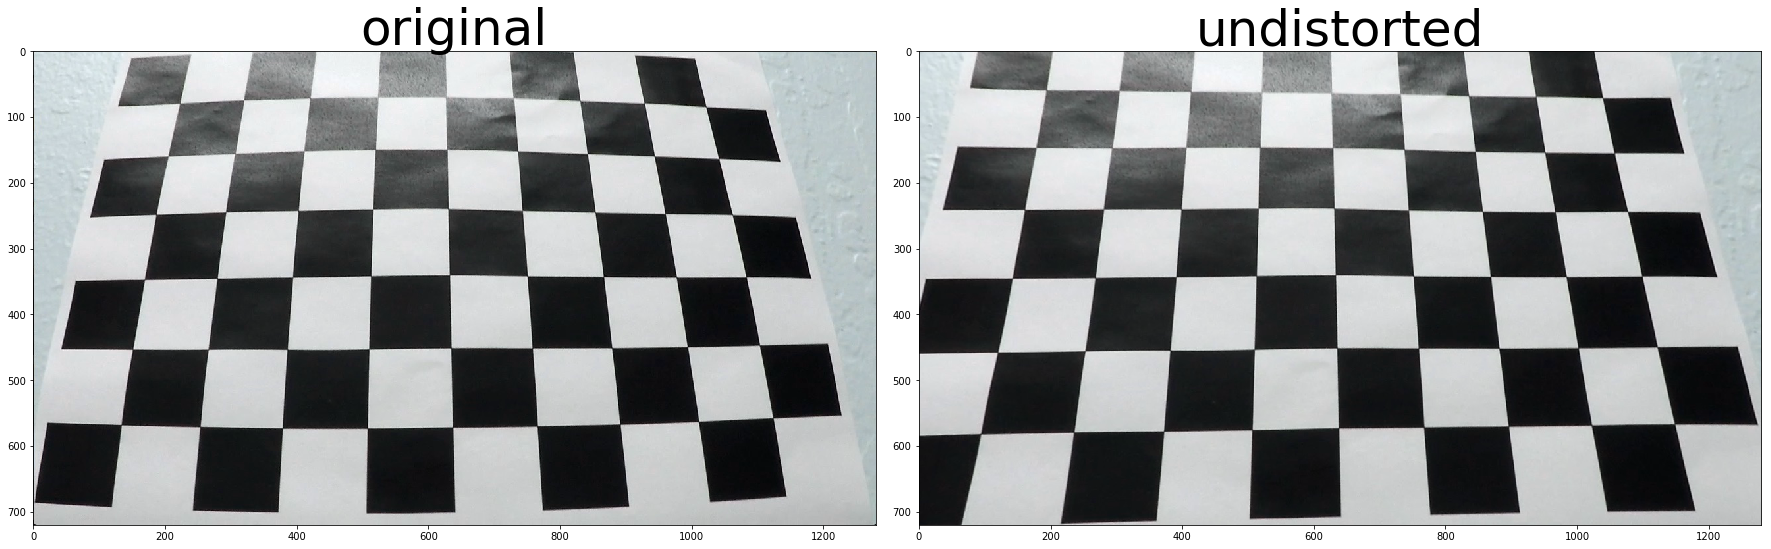

In [109]:
img = cv2.imread(images_list[0])
undistorted = obj.undistort(img)
obj.plot_image_lable(img,undistorted,'original','undistorted')

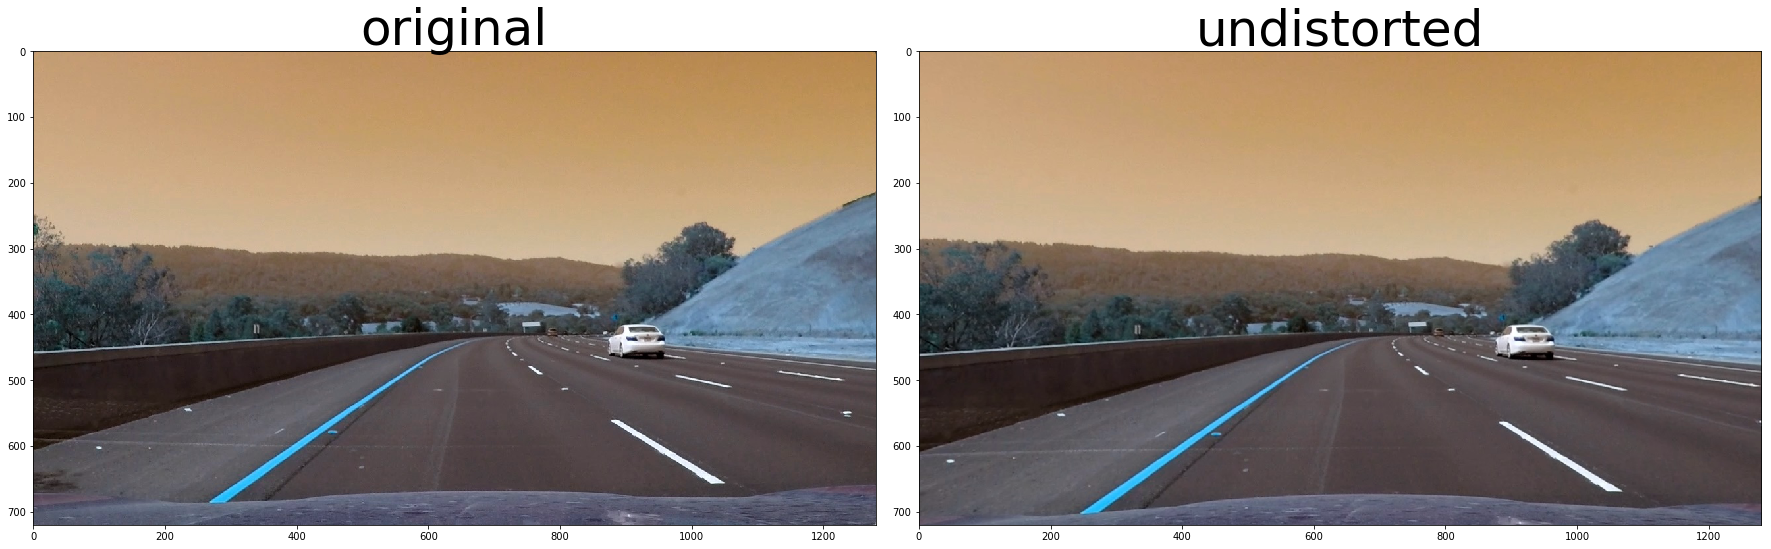

In [110]:
img = obj.read_image('test_images/test3.jpg')
undistorted = obj.undistort(img)
obj.plot_image_lable(img,undistorted,'original','undistorted')

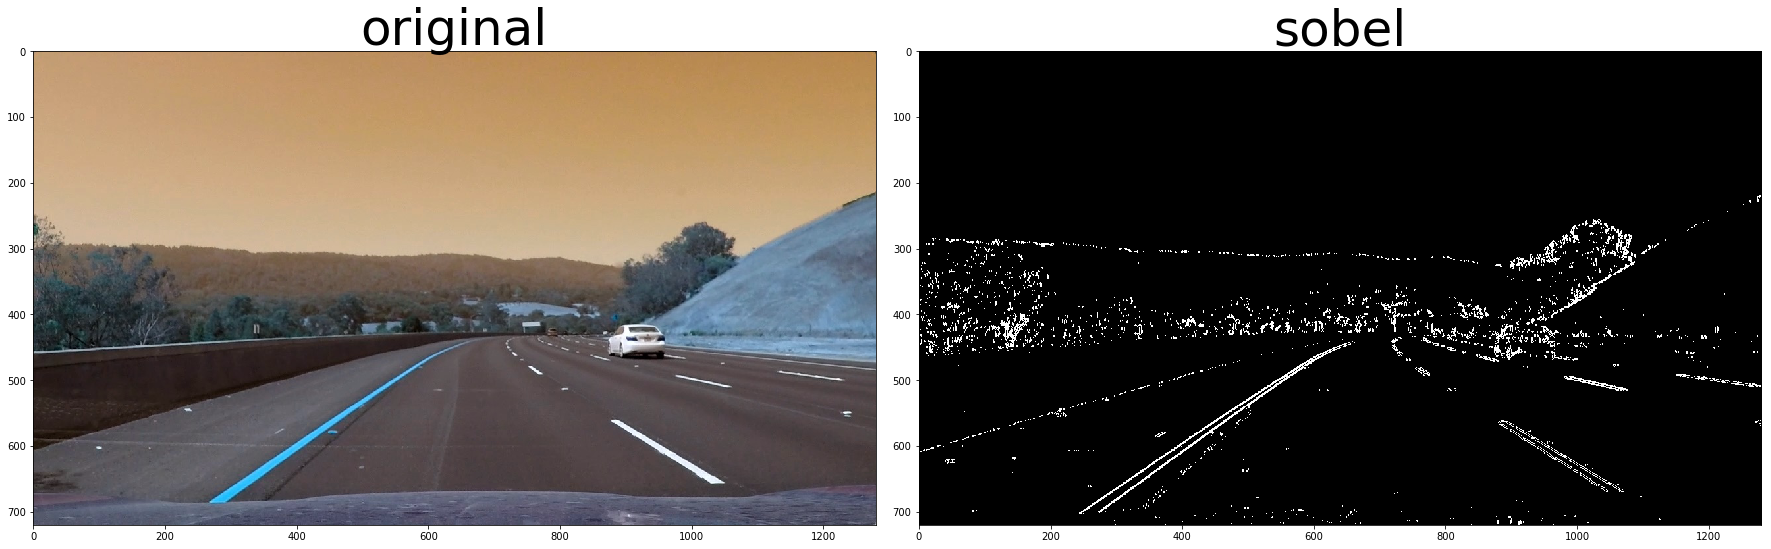

In [111]:
sobel = obj.abs_sobel_thresh();
obj.plot_image_lable(img,sobel,'original','sobel')

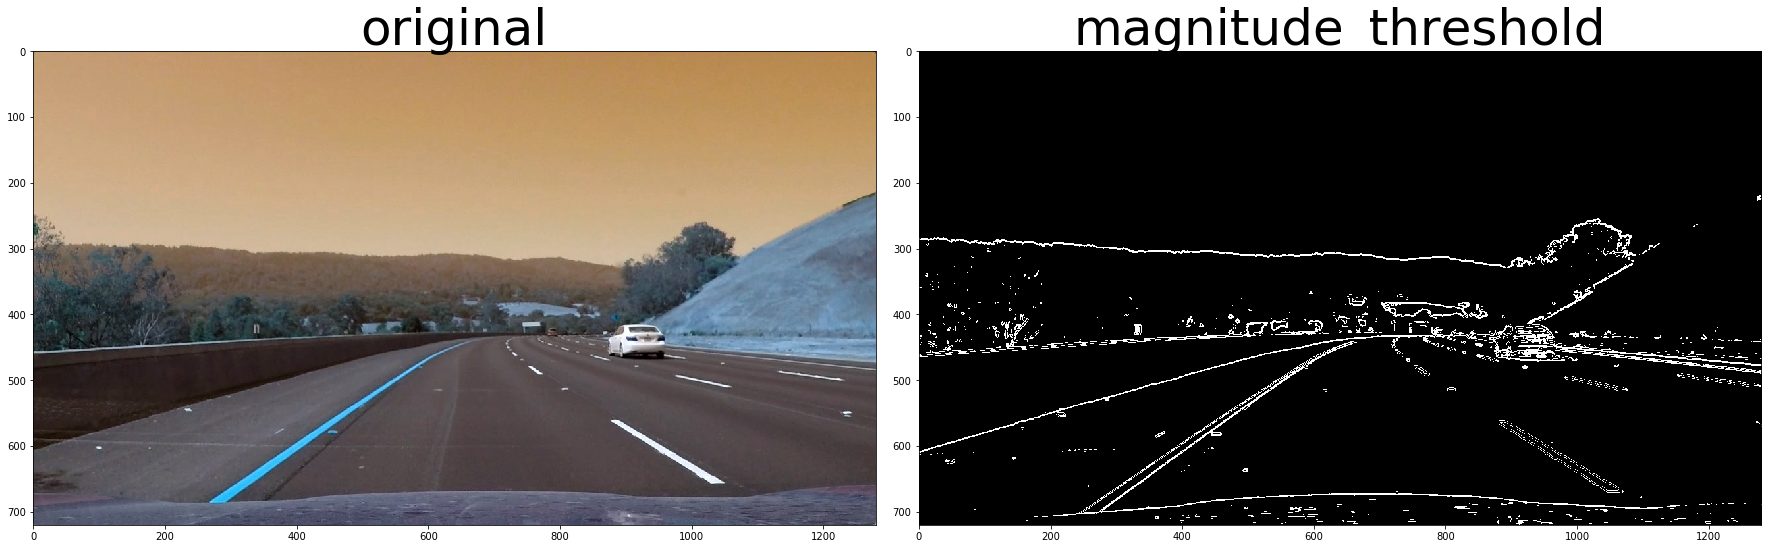

In [112]:
magnitude = obj.mag_thresh();
obj.plot_image_lable(img,magnitude,'original','magnitude_threshold')

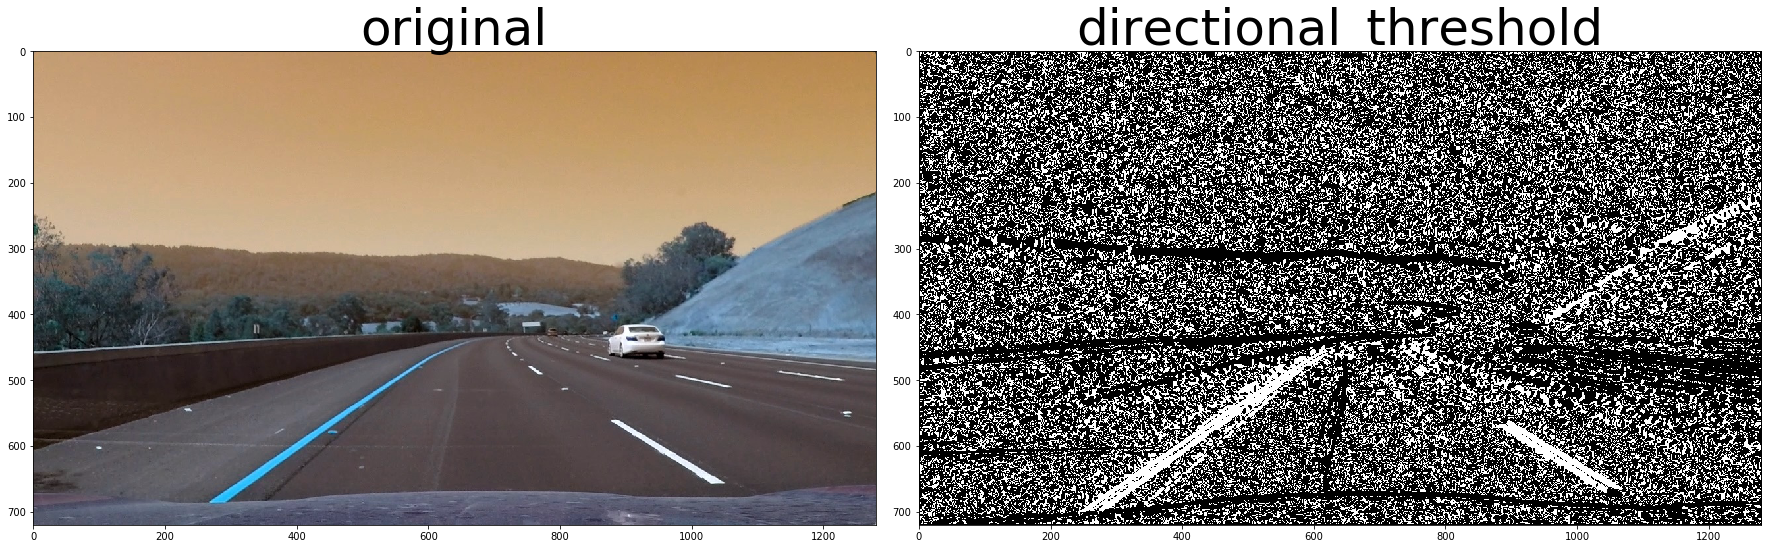

In [113]:
directional = obj.dir_threshold();
obj.plot_image_lable(img,directional,'original','directional_threshold')

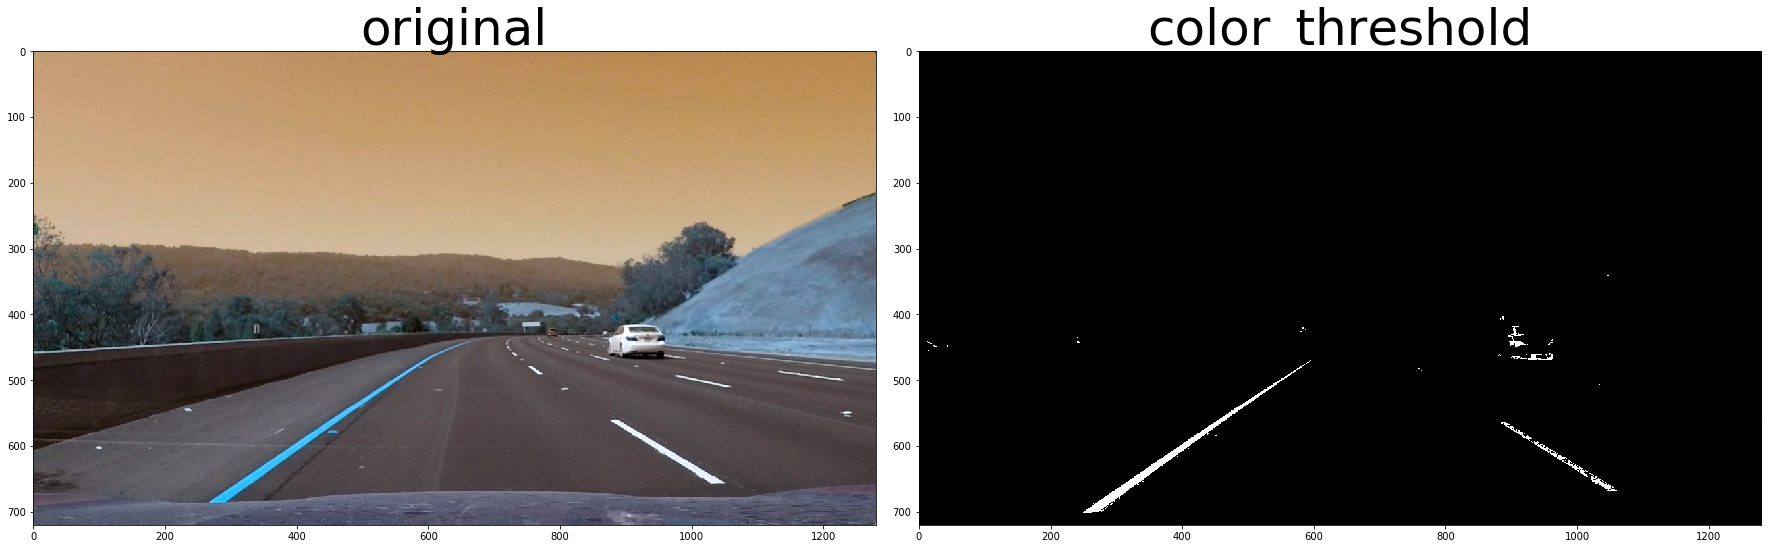

In [114]:
color_thr = obj.col_thresh();
obj.plot_image_lable(img,color_thr,'original','color_threshold')

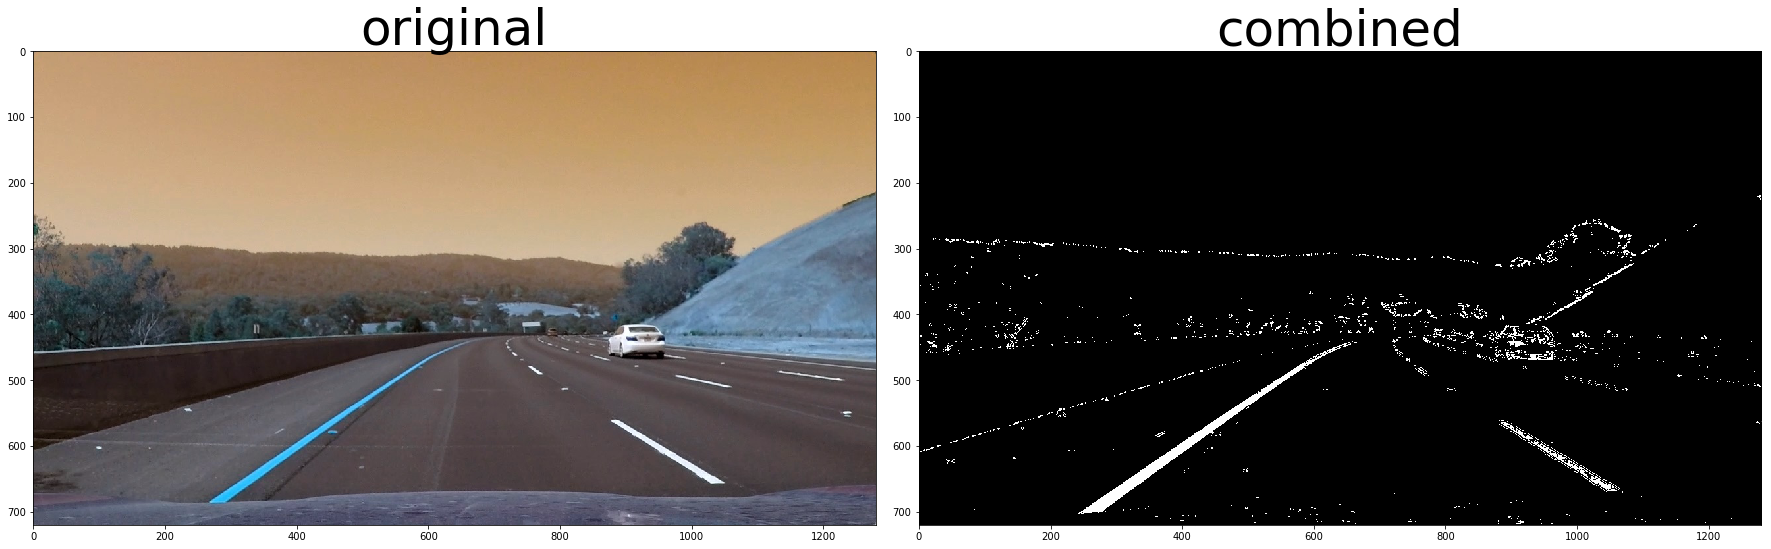

In [115]:
combined = obj.combine_thres();
obj.plot_image_lable(img,combined,'original','combined')

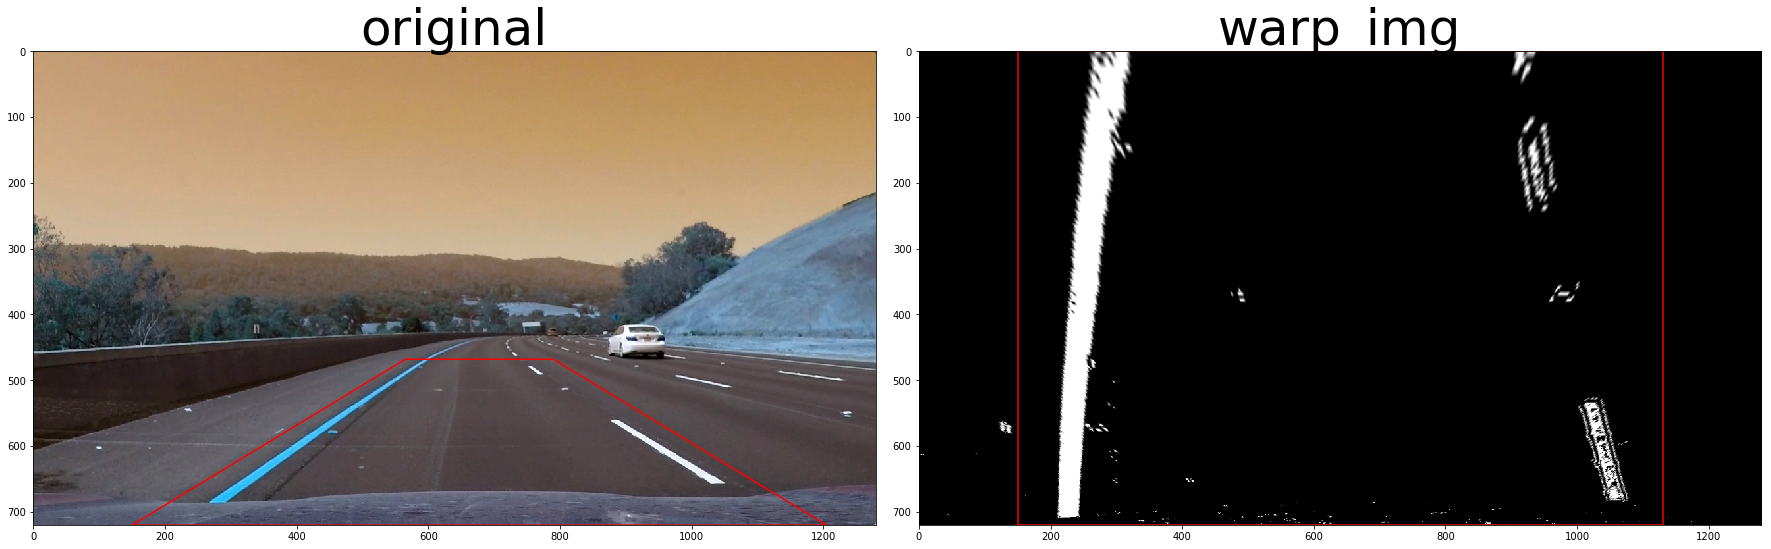

In [116]:
unwarp_img,_,_ = obj.corners_warp();
obj.plot_image_lable(img,unwarp_img,'original','warp_img',True)

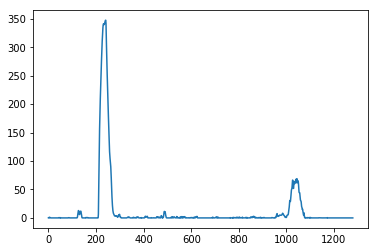

In [117]:
plt.plot(obj.hist())

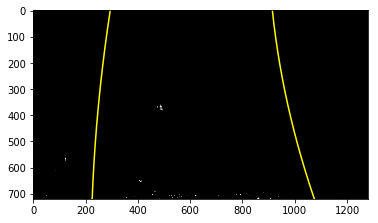

In [118]:
out_img,_,_,_ = obj.fit_polynomial(True)
plt.imshow(out_img)
#obj.plot_image_lable(unwarp_img,out_img,'warped','polynomial fit')

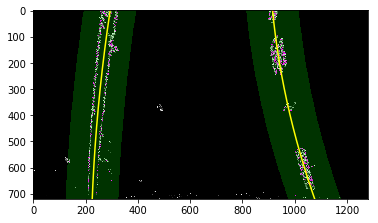

In [119]:
img_search = obj.search_around_poly()
plt.imshow(img_search)

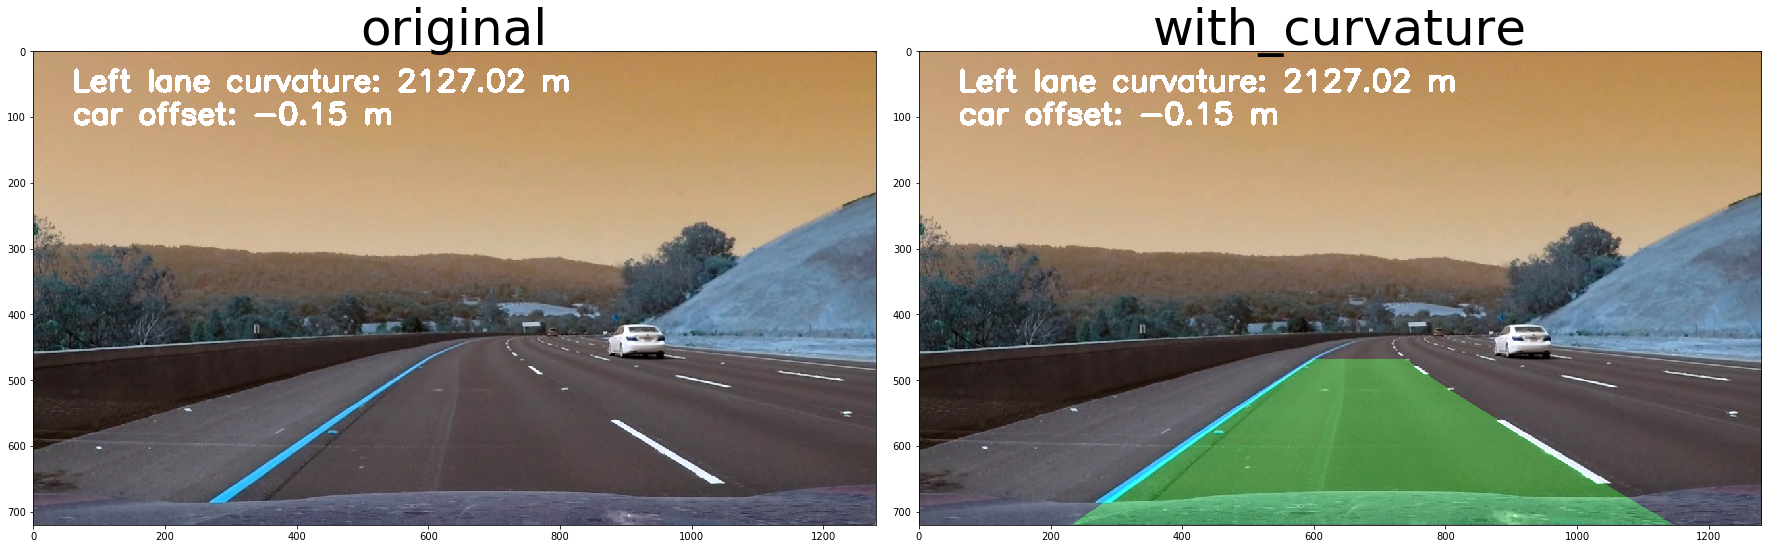

In [120]:
l_c,r_c =obj.measure_curvature()
cur_img= obj.draw_lane_curvature()
obj.plot_image_lable(img,cur_img,'original','with_curvature')

In [121]:
# Global object for Lane object
images_list = glob.glob('./camera_cal/calibration*.jpg')
obj = lane_pipeline(images_list)
obj.camera_calibration();
def image_lane_pipeline(img):  
    global obj
    #obj.camera_calibration();
    #img = obj.read_image('test_images/test3.jpg')
    obj.undistort(img)
    obj.combine_thres()
    obj.corners_warp()
    obj.search_lane()
    out_img= obj.draw_lane_curvature()
    return out_img

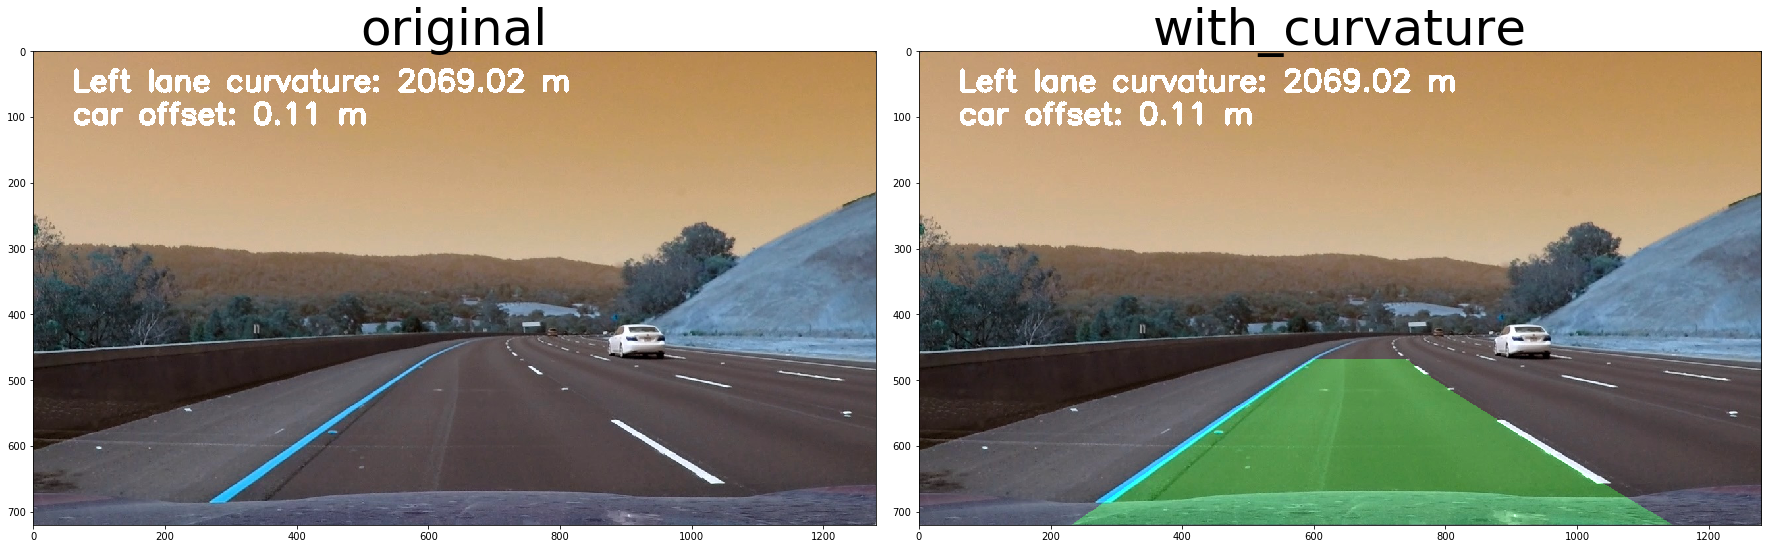

In [122]:
img = cv2.imread('test_images/test3.jpg')
out_img = image_lane_pipeline(img)
obj.plot_image_lable(img,out_img,'original','with_curvature')

In [123]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


100%|█████████▉| 1260/1261 [07:26<00:00,  2.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 5min 15s, sys: 3.74 s, total: 5min 18s
Wall time: 7min 29s


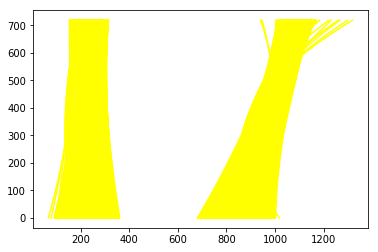

In [124]:
processed_output = './project_video_solution.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('./project_video.mp4')
yellow_clip = clip2.fl_image(image_lane_pipeline)
%time yellow_clip.write_videofile(processed_output, audio=False)

In [125]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))